# Time Constructions

Towards a usage-based, constructional taxonomy of time indicators in Biblical Hebrew.

In [214]:
import collections
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.5, style='whitegrid')
import matplotlib.pyplot as plt
from tf.fabric import Fabric
from tf.app import use

custom_data = ['/Users/cody/text-fabric-data/etcbc/bhsa/tf/c',
               '/Users/cody/github/etcbc/heads/tf/c',
               '../data/',
               '../data/funct_associations/'
              ]

TF = Fabric(locations=custom_data)
api = TF.load('''

vs vt pdp gloss lex language 
rela typ number function
g_cons_utf8 nu mother st
head nhead obj_prep sem_set
ls topAssoc TimeAssoc LocaAssoc
''')

A = use('bhsa', api=api, hoist=globals(), silent=True)

A.displaySetup(condenseType='clause', condensed=True, withNodes=True)

This is Text-Fabric 7.4.11
Api reference : https://annotation.github.io/text-fabric/Api/Fabric/

141 features found and 3 ignored
  0.00s loading features ...
   |     0.19s B g_cons_utf8          from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.12s B lex                  from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.13s B vs                   from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.12s B vt                   from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.13s B pdp                  from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.16s B gloss                from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.13s B language             from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.23s B rela                 from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.25s B typ                  from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.22s B number               from /Users

In [194]:
def findLex(lex_str):
    '''
    Finds a lex node.
    '''
    return [(l, F.gloss.v(l), F.lex.v(l)) 
                for l in F.otype.s('lex')
                if lex_str == F.lex.v(l)]

def tokenPhrase(phrasenode):
    '''
    Tokenizes a phrase with
    dot-separated words.
    input: phrase node number
    output: token string
    '''
    words = [tokenWord(w) for w in L.d(phrasenode, 'word')]
    return '.'.join(words)

# map lexeme 2 surface forms here
lex2token = {}

# map def article to ה (for cases of unconsonantal versions)
lex2token[1437572] = 'ה'

# map cardinals to מ׳׳
for lex in F.otype.s('lex'):
    if F.ls.v(lex) == 'card':
        lex2token[lex] = 'מ׳׳'

def tokenWord(wordnode, lex_mapping=lex2token):
    '''
    Tokenizes a word. If lexeme is mapped,
    uses mapped string. Otherwise uses g_cons_utf8
    '''
    lex = L.u(wordnode, 'lex')[0]
    return lex2token.get(lex, F.g_cons_utf8.v(wordnode))

## Measuring Time Phrase Dispersion

This analysis of time constructions is based on frequency. In a usage-based approach to language, highly frequent terms are the prototypes which other structures in the language are based on. In the analysis of time constructions, the top occurring surface forms, or tokens, are proposed to represent the primary means of representing time. However, raw frequencies can be misleading. For this reason, we apply a frequency adjustment as suggested by Stefan Gries.

In [195]:
time_tokens = collections.defaultdict(lambda:collections.Counter())

times = A.search('''

phrase function=Time
    word language=Hebrew lex#>K|>Z|<TH

''', shallow=True)

for tp in times:
    book, chapter, verse = T.sectionFromNode(tp)
    time_tokens[book][tokenPhrase(tp)] += 1

time_tokens = pd.DataFrame(token_freqs).fillna(0)

  1.60s 3541 results


In [196]:
time_tokens.shape

(1050, 39)

### Calculate Degree of Dispersion *DP*

In [197]:
# count all phrase tokens in all books
phrase_tokens = collections.defaultdict(lambda:collections.Counter())

for phrase in F.otype.s('phrase'):
    book, chapter, verse = T.sectionFromNode(phrase)
    phrase_tokens[book][tokenPhrase(phrase)] += 1
    
phrase_tokens = pd.DataFrame(phrase_tokens).fillna(0)

phrase_tokens.shape

(55843, 39)

In [198]:
expected_prop = phrase_tokens.sum() / phrase_tokens.sum().sum()
observed_prop = time_tokens.div(time_tokens.sum(1), axis=0)
prop_diffs = abs(expected_prop-observed_prop)
dp = pd.DataFrame(prop_diffs.sum(1) / 2, columns=['DP'])

In [201]:
dp.sort_values(by='DP').head(20)

,DP
ב.ה.בקר,0.382231
לילה,0.412077
ב.יום,0.417954
אחרי.כן,0.442750
ב.ה.יום.ה.הוא,0.444362
מ׳׳.שׁנים,0.473492
מ׳׳.שׁנה,0.475719
ה.יום,0.488443
עד.ה.יום.ה.זה,0.495352
ב.ה.ימים.ה.הם,0.503290


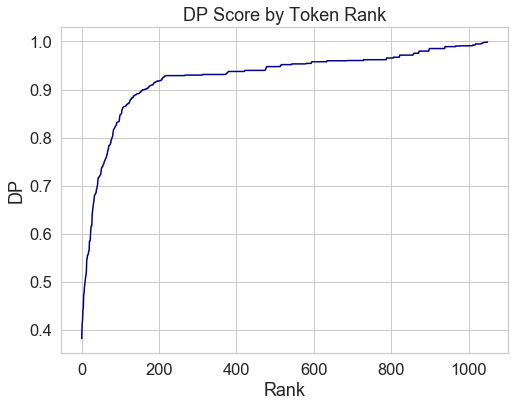

In [205]:
plt.figure(figsize=(8,6))
plt.plot(sorted(dp.values), color='darkblue')
plt.xlabel('Rank', size=18)
plt.ylabel('DP', size=18)
plt.title('DP Score by Token Rank')
plt.savefig('/Users/cody/Desktop/dp_scores.png', dpi=300)

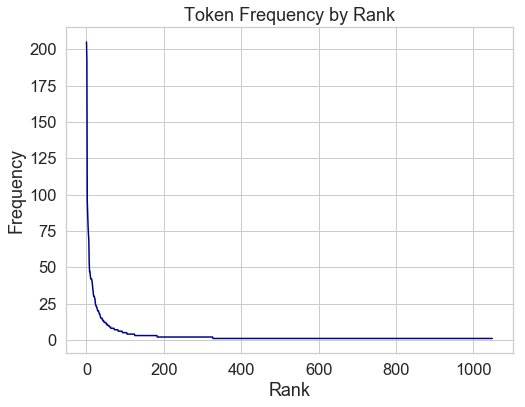

In [207]:
plt.figure(figsize=(8,6))
plt.plot(sorted(time_tokens.sum(1).values, reverse=True), color='darkblue')
plt.xlabel('Rank', size=18)
plt.ylabel('Frequency', size=18)
plt.title('Token Frequency by Rank')
plt.savefig('/Users/cody/Desktop/raw_counts.png', dpi=300)

### Queries for Similar Patterns

In [224]:
# B_H_noun = A.search('''

# phrase typ=PP function#Time
#     <head- w1:word lex=B
#     <: w2:word lex=H
#     <: w3:word pdp=subs

# w1 <obj_prep- w3
# ''')

# #A.show(B_H_noun, end=100, extraFeatures='LocaAssoc')

# # Count how many heads are associated with location
# locale = collections.Counter()

# ct = 0

# for res in B_H_noun:
#     assoc = F.LocaAssoc.v(res[3])
    
#     if not assoc:
#         continue
    
#     if assoc > int(2):
#         locale['associated'] += 1
#     else:
#         locale['not-associated'] += 1
        
#         if ct < 51: 
#             A.prettyTuple(res, seq=0, extraFeatures='LocaAssoc')
#             ct += 1
        
# locale.most_common()

In [227]:
A.show(A.search('''

phrase function#Time
    word pdp=subs
    <: word lex=H
    <: word lex=HW>

'''), end=100, extraFeatures='LocaAssoc')

  1.57s 71 results
